In [179]:
import pandas as pd
import requests
import string
string.punctuation
import re
import nltk
from nltk.stem import WordNetLemmatizer
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import(
    cross_val_score,
    train_test_split,
    GridSearchCV
)

from sklearn.preprocessing import (
    StandardScaler,
    PolynomialFeatures
)


pd.set_option('display.max_colwidth', None)

## Pre-processing

In [117]:
df_anxiety = pd.read_csv('Anxiety.csv')
df_ptsd = pd.read_csv('PTSD.csv')

In [118]:
df_anxiety = df_anxiety.drop(columns = 'Unnamed: 0')
df_ptsd.drop(columns = 'Unnamed: 0', inplace = True)

In [119]:
df = pd.concat([df_ptsd,df_anxiety])
df.reset_index(inplace = True)
df.drop(columns = 'index', inplace = True)

In [120]:
df.shape

(20298, 5)

In [121]:
# define function to remove punctuation and remove \n
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    punctuationfree = ' '.join([sentence for sentence in punctuationfree.split('\n') if sentence != ''])
    return punctuationfree

columns = ['selftext', 'title']

for col in columns:
    new_col = str('clean_' + col)
    df[new_col] = df[col].apply(lambda x: remove_punctuation(x))   

In [122]:
df.head(3)

,subreddit,selftext,title,created_utc,datetime,clean_selftext,clean_title
0,ptsd,"So, I was on tick-tock and a therapist was talking about healing PTSD and I don't know if it's my night shift brain but I thought I kinda had PTSD forever now? Like.yeah.i can learn to love with it but I wouldn't class that as healing it? Idek I'm confused and sleepy sorry for the ramble!",Can PTSD be healed?,1647751986,2022-03-20 04:53:06,So I was on ticktock and a therapist was talking about healing PTSD and I dont know if its my night shift brain but I thought I kinda had PTSD forever now Likeyeahi can learn to love with it but I wouldnt class that as healing it Idek Im confused and sleepy sorry for the ramble,Can PTSD be healed
1,ptsd,"I just need to share this and my feelings about it somewhere. It's too personal for my regular social media but I have to put it into writing in some way.\n\nI've been avoiding googling my abusive ex boyfriend for ten years. Just thinking about him made me sick. Two years ago I finally got trauma therapy to deal with what he did to me. Constant humiliation, degradation, sexual abuse and rape. \n\nTonight I randomly felt curious about where he would be in life now, so I googled him. Turns out he died two years ago, about the same time as my trauma therapy started. I found this webpage where his friends and family had written how much they missed him. How they'd never forget his smile, the same smile that makes my skin crawl just thinking about it. \n\nI've never felt happy about anyone's death before but I actually feel like celebrating. It's not relief because he was already out of my life and I was never scared of him showing up or hurting me again. It's just.. triumph. I still suffer the consequences of what he did to me. I still can't make relationships work and I still flinch when men get close to touching me because of him. I'm not ashamed to say that I hope he suffered before he died.\n\nThere's not much to discuss here I guess, I just didn't know where else to share this honestly.",Just found out my abuser is dead,1647747979,2022-03-20 03:46:19,I just need to share this and my feelings about it somewhere Its too personal for my regular social media but I have to put it into writing in some way Ive been avoiding googling my abusive ex boyfriend for ten years Just thinking about him made me sick Two years ago I finally got trauma therapy to deal with what he did to me Constant humiliation degradation sexual abuse and rape Tonight I randomly felt curious about where he would be in life now so I googled him Turns out he died two years ago about the same time as my trauma therapy started I found this webpage where his friends and family had written how much they missed him How theyd never forget his smile the same smile that makes my skin crawl just thinking about it Ive never felt happy about anyones death before but I actually feel like celebrating Its not relief because he was already out of my life and I was never scared of him showing up or hurting me again Its just triumph I still suffer the consequences of what he did to me I still cant make relationships work and I still flinch when men get close to touching me because of him Im not ashamed to say that I hope he suffered before he died Theres not much to discuss here I guess I just didnt know where else to share this honestly,Just found out my abuser is dead
2,ptsd,"I was kidnapped at the age of 22 by a psychotic maniac on the run from the law and held against my will for 11 months\nIt was hell. Everyday was hell. Of course I now have complex PTSD. I'm 64 now and am still traumatized. My whole life was ruined by the time I was 23. I never got married, never had kids. I've been a loner ever since. I still get intrusive memories of horrific child abuse. I don't know why I'm even posting this. But I know people here understand.",PTSD never goes away... I'm tired of it,1647747031,2022-03-20 03:30:31,I was kidnapped at the age of 22 by a psychotic maniac o

In [123]:
# changing all to lower caps 

columns = ['clean_selftext', 'clean_title']

for col in columns:
    new_col = str('lower_' + col.split('_')[1])
    df[new_col] = df[col].apply(lambda x: x.lower())   

In [124]:
df['subreddit'].value_counts()

ptsd       10188
Anxiety    10110
Name: subreddit, dtype: int64

In [125]:
df.head(3)

,subreddit,selftext,title,created_utc,datetime,clean_selftext,clean_title,lower_selftext,lower_title
0,ptsd,"So, I was on tick-tock and a therapist was talking about healing PTSD and I don't know if it's my night shift brain but I thought I kinda had PTSD forever now? Like.yeah.i can learn to love with it but I wouldn't class that as healing it? Idek I'm confused and sleepy sorry for the ramble!",Can PTSD be healed?,1647751986,2022-03-20 04:53:06,So I was on ticktock and a therapist was talking about healing PTSD and I dont know if its my night shift brain but I thought I kinda had PTSD forever now Likeyeahi can learn to love with it but I wouldnt class that as healing it Idek Im confused and sleepy sorry for the ramble,Can PTSD be healed,so i was on ticktock and a therapist was talking about healing ptsd and i dont know if its my night shift brain but i thought i kinda had ptsd forever now likeyeahi can learn to love with it but i wouldnt class that as healing it idek im confused and sleepy sorry for the ramble,can ptsd be healed
1,ptsd,"I just need to share this and my feelings about it somewhere. It's too personal for my regular social media but I have to put it into writing in some way.\n\nI've been avoiding googling my abusive ex boyfriend for ten years. Just thinking about him made me sick. Two years ago I finally got trauma therapy to deal with what he did to me. Constant humiliation, degradation, sexual abuse and rape. \n\nTonight I randomly felt curious about where he would be in life now, so I googled him. Turns out he died two years ago, about the same time as my trauma therapy started. I found this webpage where his friends and family had written how much they missed him. How they'd never forget his smile, the same smile that makes my skin crawl just thinking about it. \n\nI've never felt happy about anyone's death before but I actually feel like celebrating. It's not relief because he was already out of my life and I was never scared of him showing up or hurting me again. It's just.. triumph. I still suffer the consequences of what he did to me. I still can't make relationships work and I still flinch when men get close to touching me because of him. I'm not ashamed to say that I hope he suffered before he died.\n\nThere's not much to discuss here I guess, I just didn't know where else to share this honestly.",Just found out my abuser is dead,1647747979,2022-03-20 03:46:19,I just need to share this and my feelings about it somewhere Its too personal for my regular social media but I have to put it into writing in some way Ive been avoiding googling my abusive ex boyfriend for ten years Just thinking about him made me sick Two years ago I finally got trauma therapy to deal with what he did to me Constant humiliation degradation sexual abuse and rape Tonight I randomly felt curious about where he would be in life now so I googled him Turns out he died two years ago about the same time as my trauma therapy started I found this webpage where his friends and family had written how much they missed him How theyd never forget his smile the same smile that makes my skin crawl just thinking about it Ive never felt happy about anyones death before but I actually feel like celebrating Its not relief because he was already out of my life and I was never scared of him showing up or hurting me again Its just triumph I still suffer the consequences of what he did to me I still cant make relationships work and I still flinch when men get close to touching me because of him Im not ashamed to say that I hope he suffered before he died Theres not much to discuss here I guess I just didnt know where else to share this honestly,Just found out my abuser is dead,i just need to share this and my feelings about it somewhere its too personal for my regular social media but i have to put it into writing in some way ive been avoiding googling my abusive ex boyfriend for ten years just thinking about him made me sick two years ago i finally g

In [126]:
# import clinical stop words 
clinal_stopwords = pd.read_csv('Clinical_stopwords.txt')

In [127]:
# create stop word list 
stopwordlist = nltk.corpus.stopwords.words('english')

# to input in subreddit headers so that we can exclude it for model
headers = ['ptsd', 'anxiety']
for head in headers:
    stopwordlist.append(head)

# for word in clinal_stopwords['x'].tolist():
#     stopwordlist.append(word)

stopwordlist


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [128]:
df['subreddit'] = df['subreddit'].map(lambda x: 1 if x == 'ptsd' else 0)

## Modeling

In [129]:
# declare X and y

X = df['lower_selftext']
y = df['subreddit']

In [130]:
# Train test split 
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words = stopwordlist)),
    ('lr', LogisticRegression())
])

In [131]:
pipe.get_params()

{'memory': None,
 'steps': [('cvec',
   CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                               'ourselves', 'you', "you're", "you've", "you'll",
                               "you'd", 'your', 'yours', 'yourself', 'yourselves',
                               'he', 'him', 'his', 'himself', 'she', "she's",
                               'her', 'hers', 'herself', 'it', "it's", 'its',
                               'itself', ...])),
  ('lr', LogisticRegression())],
 'verbose': False,
 'cvec': CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                             'ourselves', 'you', "you're", "you've", "you'll",
                             "you'd", 'your', 'yours', 'yourself', 'yourselves',
                             'he', 'him', 'his', 'himself', 'she', "she's",
                             'her', 'hers', 'herself', 'it', "it's", 'its',
                             'itself', ...]),
 'lr': LogisticRegre

In [156]:
pipe_params = {
    'cvec__max_features': [1_000, 2_000],
    'cvec__min_df': [0.001, .002, .005],
    'cvec__max_df': [.6, .7, .8],
    'cvec__ngram_range': [(1,1), (1,2)],
    'lr__max_iter': [1000]
}

gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation

gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
  

In [157]:
# What's the best score?
print(gs.best_score_)

0.8081473779287368


0.8074855320944119

In [158]:
# What's the best score?
print(gs.best_estimator_)

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.6, max_features=1000, min_df=0.002,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('lr', LogisticRegression(max_iter=1000))])


In [159]:
# Score model on training set.
print(gs.score(X_train, y_train))

0.8524891536142364


In [160]:
# Score model on testing set.
print(gs.score(X_test, y_test))

0.8181818181818182


In [161]:
# Get predictions
preds = gs.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

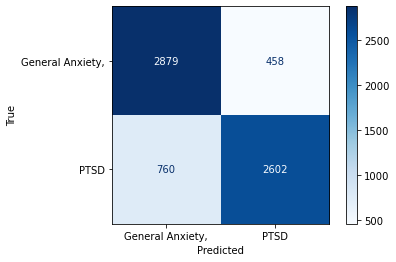

In [162]:
# View confusion matrix
cmd = plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d', display_labels=['General Anxiety,','PTSD'])
cmd.ax_.set(xlabel='Predicted', ylabel='True');

In [163]:
# to create dataframe of highest coefficients 

df = pd.DataFrame([[x,y] for x,y in zip(gs.best_estimator_[0].get_feature_names(), gs.best_estimator_[1].coef_.tolist()[0])])
df.rename(columns= {0: 'Features', 1: 'Coefficients'}, inplace = True)
df.sort_values(by = 'Coefficients', ascending = False).head(20)


,Features,Coefficients
313,flashbacks,3.415771
13,abuser,3.079983
684,raped,2.928062
172,cptsd,2.736422
312,flashback,2.651252
683,rape,2.419575
891,traumatic,2.409773
12,abused,2.256659
890,trauma,2.225944
592,nightmares,2.224532


In [168]:
# Train test split 
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words = stopwordlist)),
    ('nb', MultinomialNB())
])

pipe_params = {
    'cvec__max_features': [1_000, 2_000],
    'cvec__min_df': [0.001, .002, .005],
    'cvec__max_df': [.6, .7, .8],
    'cvec__ngram_range': [(1,1), (1,2)],
}

gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation

gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
  

In [169]:
# What's the best score?
print('Best score:', gs.best_score_)

# Score model on training set.
print('Best training score:', gs.score(X_train, y_train))

# Score model on testing set.
print('Best test score:', gs.score(X_test, y_test))

Best score: 0.8156476213140644
Best training score: 0.8269725715126113
Best test score: 0.8272876548738618


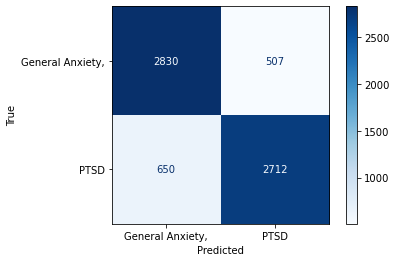

In [170]:
# Get predictions
preds = gs.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# View confusion matrix
cmd = plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d', display_labels=['General Anxiety,','PTSD'])
cmd.ax_.set(xlabel='Predicted', ylabel='True');

In [178]:
# to create dataframe of highest coefficients 

df = pd.DataFrame([[x,y] for x,y in zip(gs.best_estimator_[0].get_feature_names(), np.exp(gs.best_estimator_[1].coef_).tolist()[0])])
df.rename(columns= {0: 'Features', 1: 'Coefficients'}, inplace = True)
df.sort_values(by = 'Coefficients', ascending = False).head(20)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


,Features,Coefficients
1009,like,0.016801
892,im,0.012657
646,feel,0.012310
961,know,0.010218
736,get,0.009215
1786,time,0.008042
580,even,0.007766
1408,really,0.007479
1907,want,0.007093
507,dont,0.007026


In [181]:
# Train test split 
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

pipe = Pipeline([
    ('tfid', TfidfVectorizer(stop_words = stopwordlist)),
    ('nb', MultinomialNB())
])

pipe_params = {
    'tfid__max_features': [1_000, 2_000],
    'tfid__min_df': [0.001, .002, .005],
    'tfid__max_df': [.6, .7, .8],
    'tfid__ngram_range': [(1,1), (1,2)],
}

gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation

gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfid',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
  

In [182]:
# What's the best score?
print('Best score:', gs.best_score_)

# Score model on training set.
print('Best training score:', gs.score(X_train, y_train))

# Score model on testing set.
print('Best test score:', gs.score(X_test, y_test))

Best score: 0.8177804610258963
Best training score: 0.8360173542172219
Best test score: 0.8329601433049709


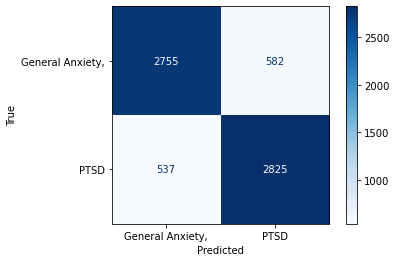

In [183]:
# Get predictions
preds = gs.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# View confusion matrix
cmd = plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d', display_labels=['General Anxiety,','PTSD'])
cmd.ax_.set(xlabel='Predicted', ylabel='True');

In [184]:
# to create dataframe of highest coefficients 

df = pd.DataFrame([[x,y] for x,y in zip(gs.best_estimator_[0].get_feature_names(), np.exp(gs.best_estimator_[1].coef_).tolist()[0])])
df.rename(columns= {0: 'Features', 1: 'Coefficients'}, inplace = True)
df.sort_values(by = 'Coefficients', ascending = False).head(20)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


,Features,Coefficients
1009,like,0.007310
892,im,0.007022
646,feel,0.006289
961,know,0.005370
736,get,0.004699
1907,want,0.004405
1408,really,0.004350
507,dont,0.004338
1816,trauma,0.004190
1786,time,0.004076


In [185]:
# # split into single words 

# columns = ['lower_selftext', 'lower_title']

# for col in columns:
#     new_col = str('split_' + col.split('_')[1])
#     df[new_col] = df[col].apply(lambda x: x.split())   

In [186]:
# #Stop words present in the library
# stopwords = nltk.corpus.stopwords.words('english')
# stopwords[0:10]

# #defining the function to remove stopwords from tokenized text
# def remove_stopwords(text):
#     output= [i for i in text if i not in stopwords]
#     return output

# columns = ['split_selftext', 'split_title']

# for col in columns:
#     new_col = str('stopwords_' + col.split('_')[1])
#     df[new_col] = df[col].apply(lambda x:remove_stopwords(x))   

In [187]:
# #defining the object for Lemmatization
# wordnet_lemmatizer = WordNetLemmatizer()

# #defining the function for lemmatization
# def lemmatizer(text):
#     lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
#     return lemm_text

# columns = ['stopwords_selftext', 'stopwords_title']

# for col in columns:
#     new_col = str('lemmatized_' + col.split('_')[1])
#     df[new_col] = df[col].apply(lambda x:lemmatizer(x))   